This notebook goes over some basic visualizations of the training data for this competition. We can get some insight into how we might extend our analyses beyond simple regression models, and we can also see that there are many potential difficulties in making good predictions.

First, we'll just load some packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

Now, we'll read the training data. I'm going to fill the NaN values with 0 since the dataset does not distinguish between 0 and missing. We'll have to deal with these later.

In [2]:
train = pd.read_csv('../input/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


To save some memory, I'll downcast everything to an integer. In Pandas, you can't automatically set columns with NaN values to integer types on reading the file, so I'll do this after. This should reduce the size in memory from 600 Mbyte to 300 Mbyte. Views are an integer type anyway so this isn't losing any info. We might want our predictions to be floating point, though.

In [3]:
# Commented out for now to stop errors with some of the statsmodels methods
#for col in train.columns[1:]:
#    train[col] = pd.to_numeric(train[col],downcast='integer')
#train.head()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


# Is Traffic Influenced by Page Language?
One thing that might be interesting to look it is how the different languages used in Wikipedia might affect the dataset. I'll use a simple regular expression to search for the language code in the wikipedia URL. There are also a number of non-wikipedia URLs that will fail the regex search. These are wikimedia pages, so I'll give them the code 'na' since I haven't determined their language. Many of these will be things like images that do not really have a language.

In [5]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish. This will make any analysis of the URLs difficult since there are four different writing systems to be dealt with (Latin, Cyrillic, Chinese, and Japanese). Here, I will create dataframes for the different types of entries. I will then calculate the sum of all views. I would note that because the data comes from several different sources, the sum will likely be double counting some of the views.

In [6]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

So then how does the total number of views change over time?
I'll plot all the different sets on the same plot. 

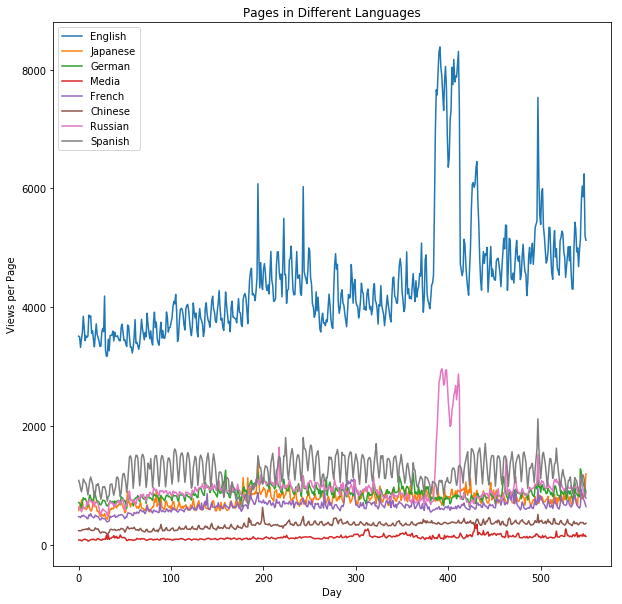

In [7]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()


English shows a much higher number of views per page, as might be expected since Wikipedia is a US-based site. There is a lot more structure here than I would have expected. The English and Russian plots show very large spikes around day 400 (around August 2016), with several more spikes in the English data later in 2016. My guess is that this is the effect of both the Summer Olympics in August and the election in the US.

There's also a strange feature in the English data around day 200. 

The Spanish data is very interesting too. There is a clear periodic structure there, with a ~1 week fast period and what looks like a significant dip around every 6 months or so.

# Periodic Structure and FFTs

Since it looks like there is some periodic structure here, I will plot each of these separately so that the scale is more visible. Along with the individual plots, I will also look at the magnitude of the Fast Fourier Transform (FFT). Peaks in the FFT show us the strongest frequencies in the periodic signal.

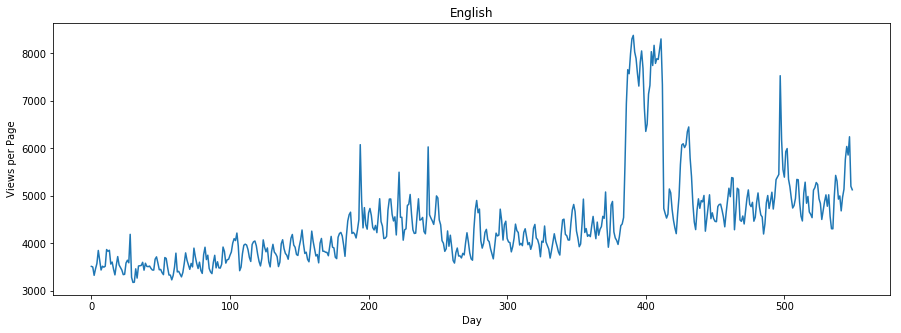

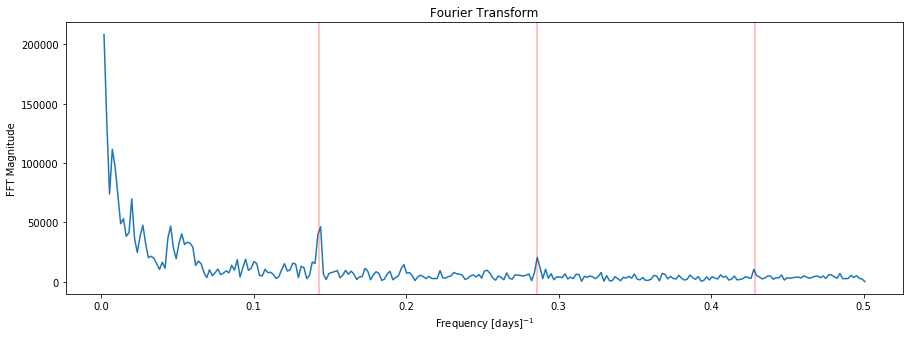

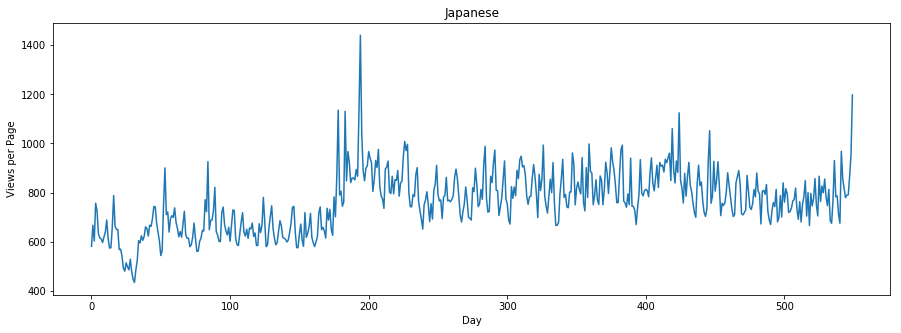

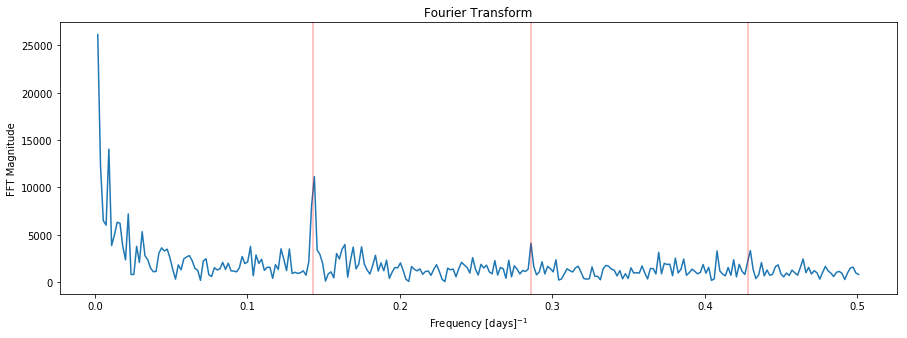

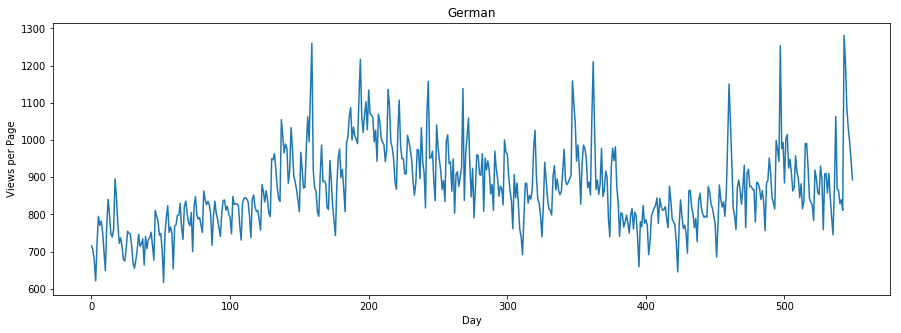

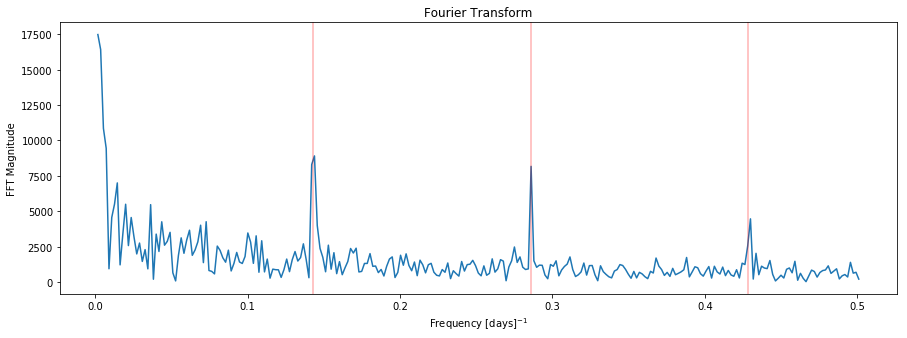

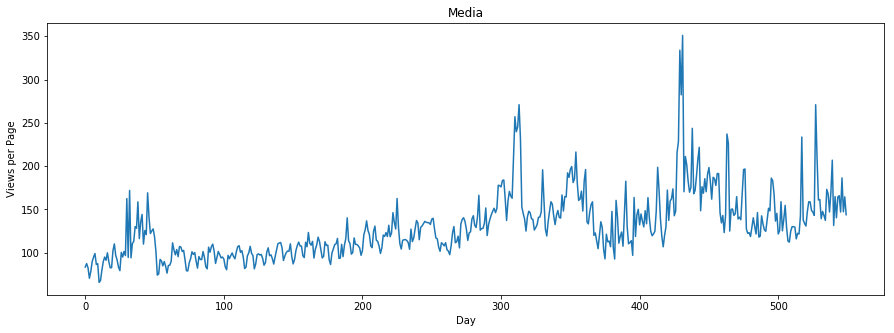

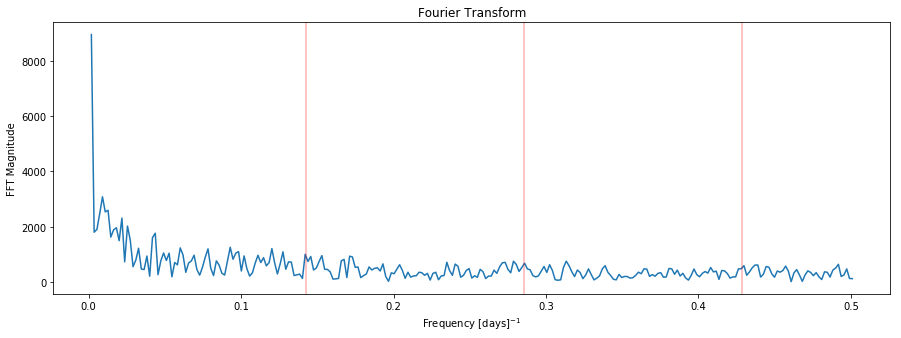

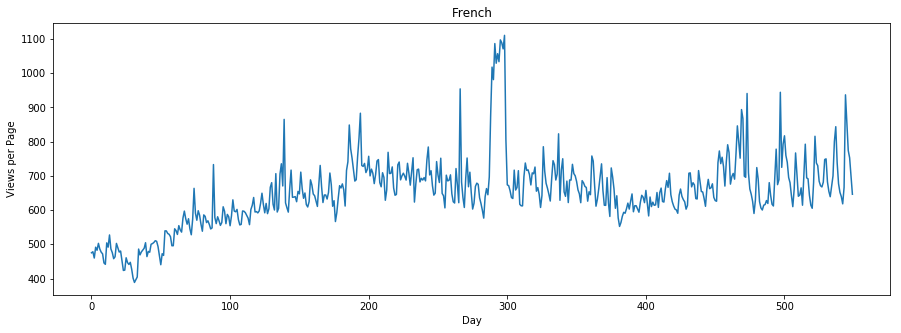

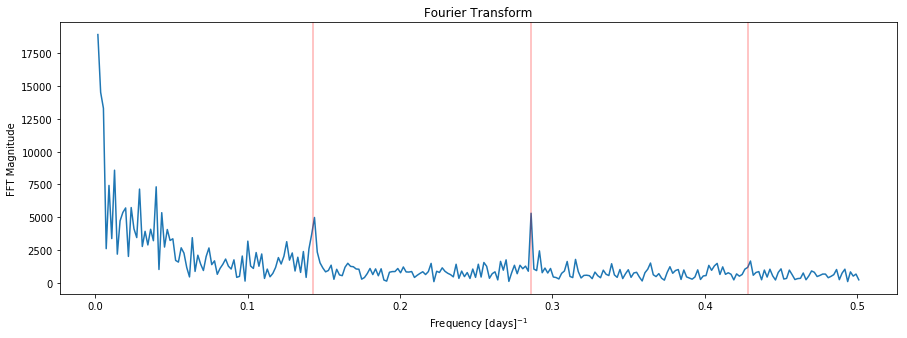

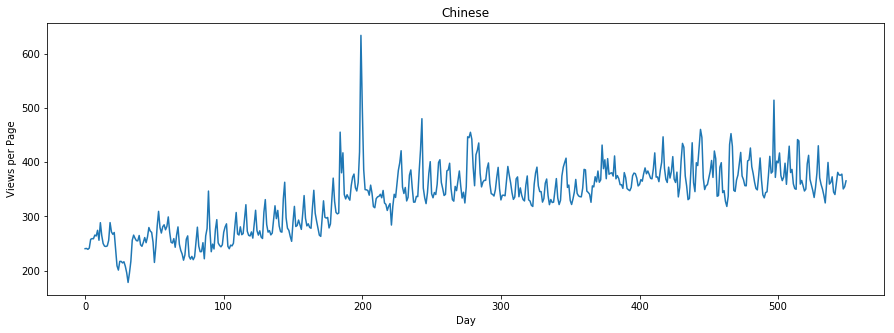

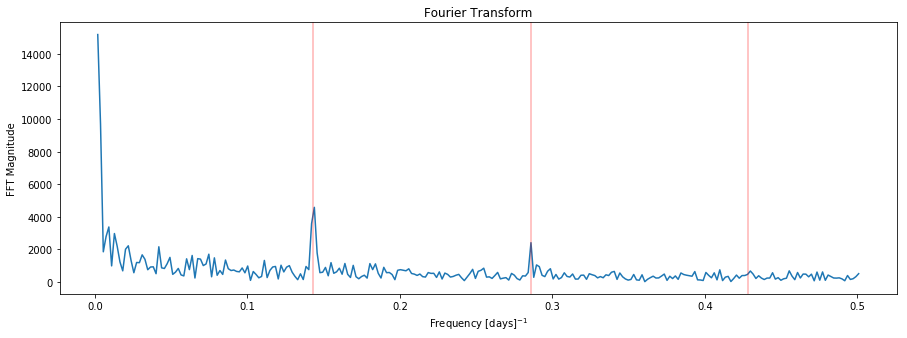

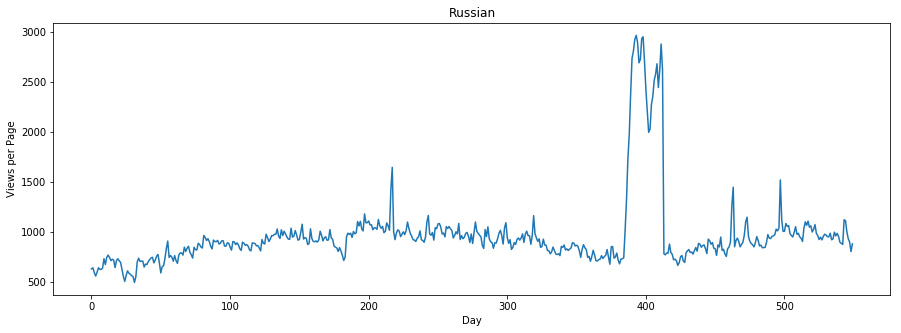

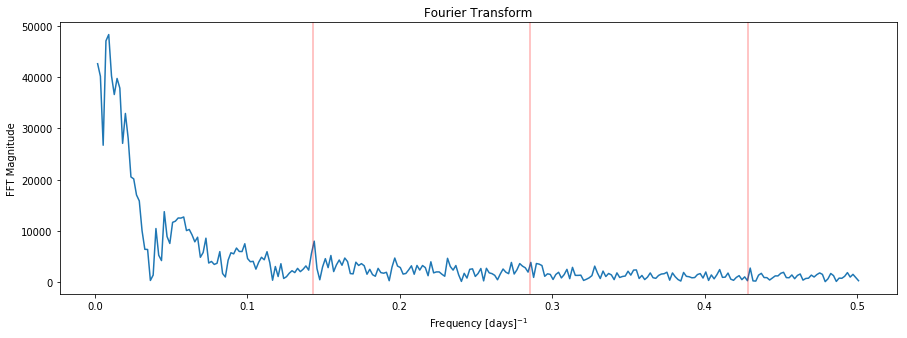

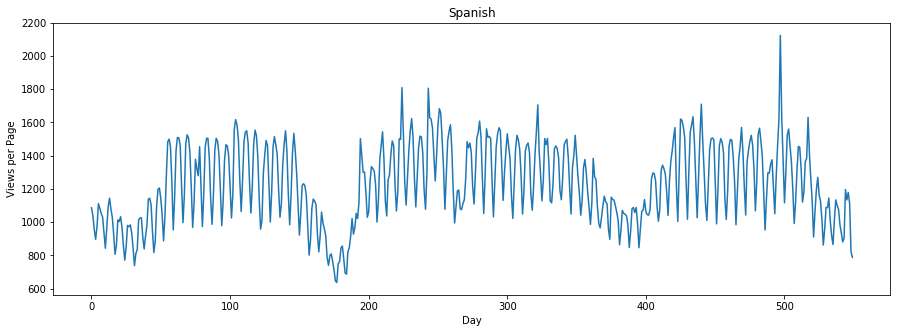

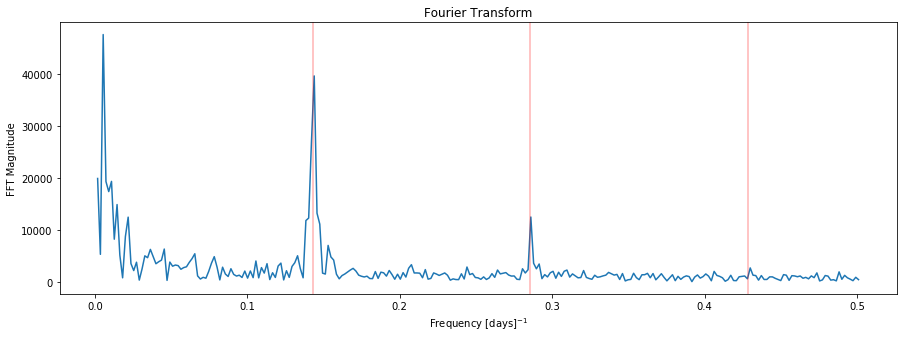

In [8]:
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_with_fft(key)

From this we see that while the Spanish data has the strongest periodic features, most of the other languages show some periodicity as well. For some reason the Russian and media data do not seem to show much. I plotted red lines where a period of 1, 1/2, and 1/3 week would appear. We see that the periodic features are mainly at 1 and 1/2 week. This is not surprising since browsing habits may differ on weekdays compared to weekends, leading to peaks in the FFTs at frequencies of n/(1 week) for integer n.
So, we've learned now that page views are not at all smooth. There is some regular variation from day to day, but there are also large effects that can happen quite suddenly. A model likely will not be able to predict the sudden spikes unless it can be fed more information about what is going on in the world that day.

# Individual Entry Data

Now, I'll plot the data for some individual entries. I've picked some entries to look at, but there's not necessarily anything special about them.

In [9]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

First, let's look at some English pages.

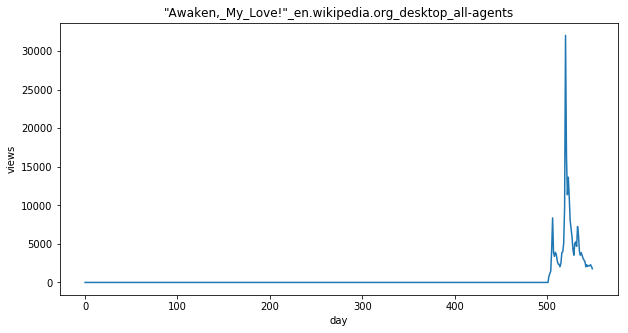

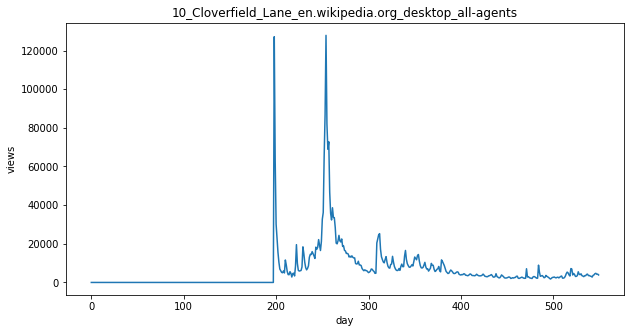

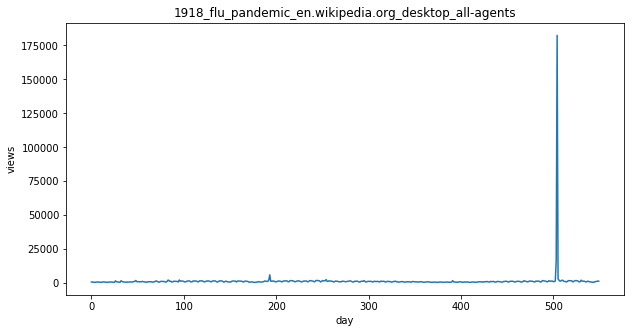

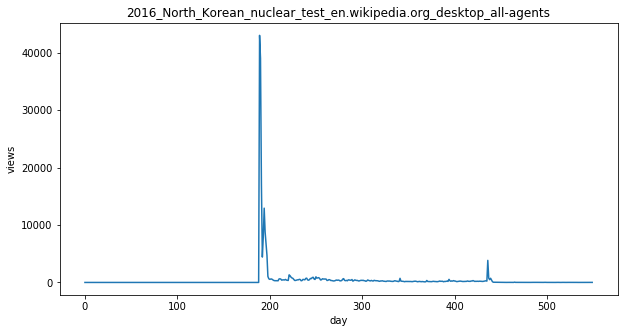

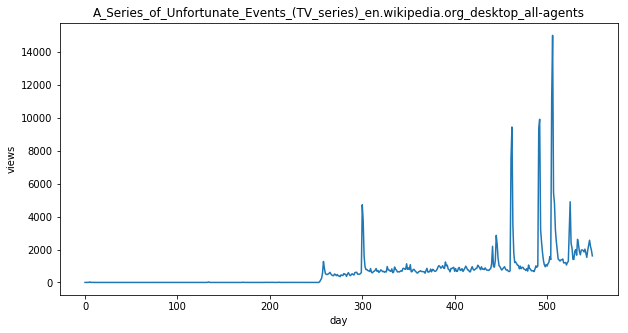

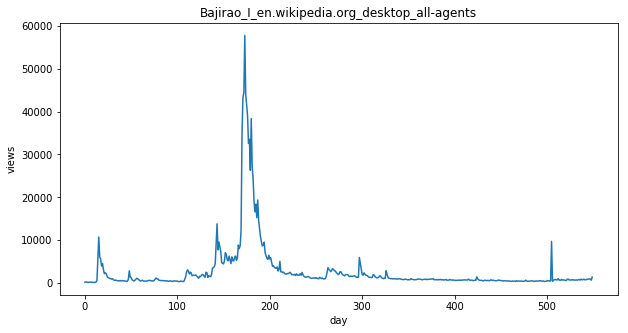

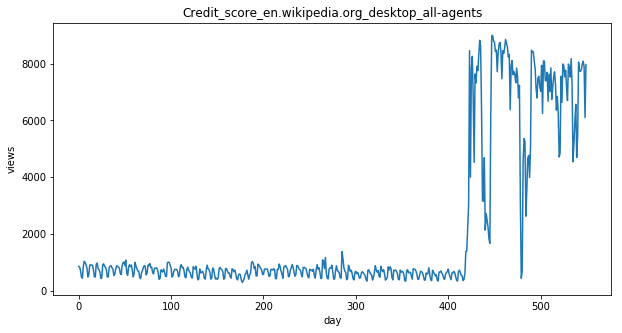

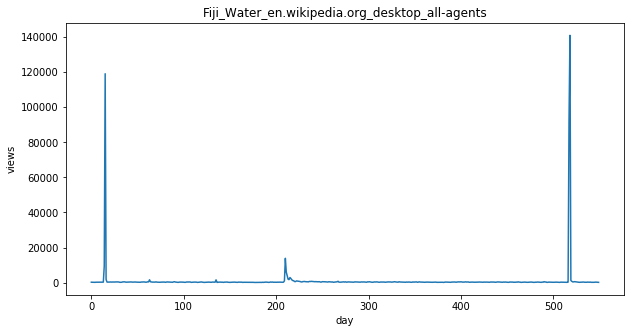

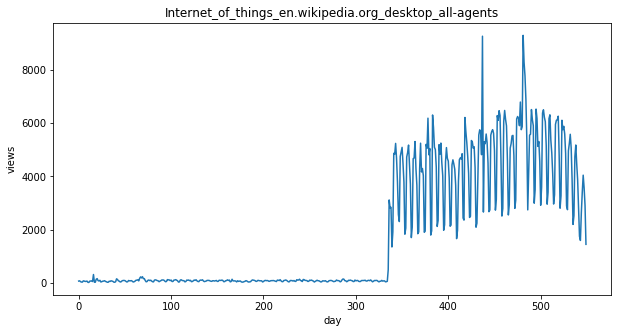

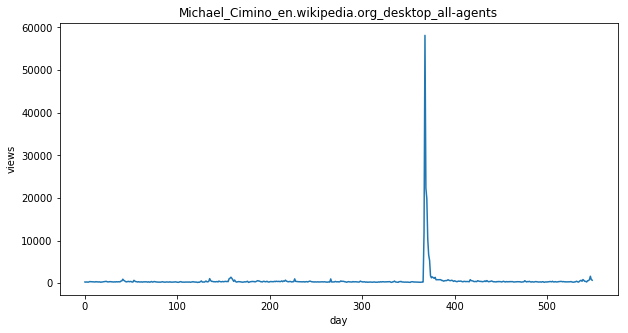

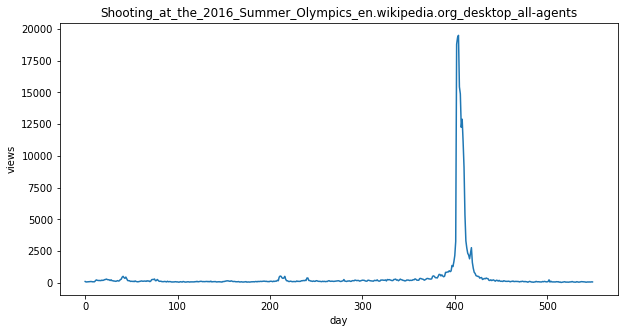

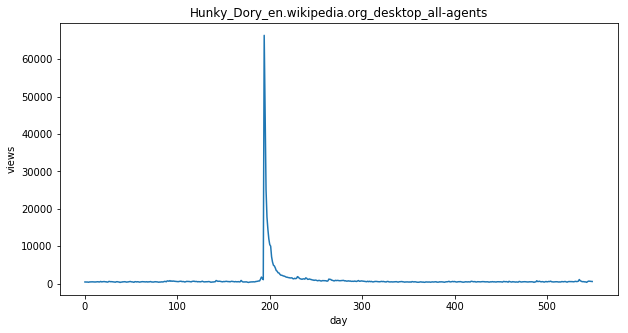

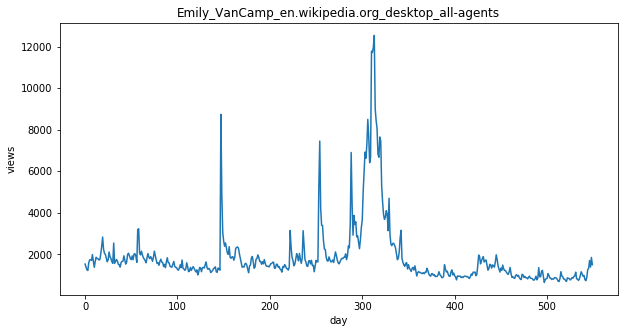

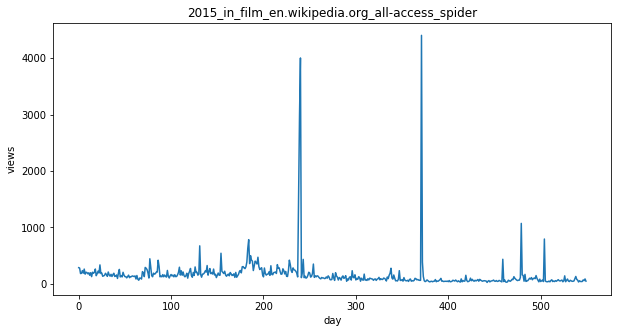

In [10]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1000,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('en',i)

We see that for individual pages, the data is also not smooth. There are sudden gigantic spikes, large shifts in the mean number of views, and other things. We can also clearly see the effects of current events on Wikipedia views. 

The 2016 North Korean nuclear test occurred, and a Wikipedia page was quickly constructed and received a huge number of views in a short time. The number of views mostly decayed away in 1 or 2 weeks.

Hunky Dory received a large number of viewers around the beginning of 2016, corresponding to the death of David Bowie.

The page about the shooting competition at the 2016 Olympics had a small number of views and then suddenly a lot right around the Olympics.

There are also some oddities, like two huge spikes in the data for Fiji Water, and the sudden long-term increases in traffic to "Internet of Things" and "Credit score." Maybe there were some news stories about Fiji water on those days. For the others, maybe there was a change in search engine behavior or maybe some new links appeared in very visible locations. 

Now I'll look at some Spanish entries.

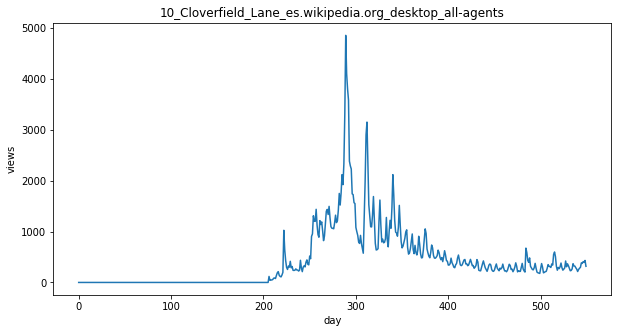

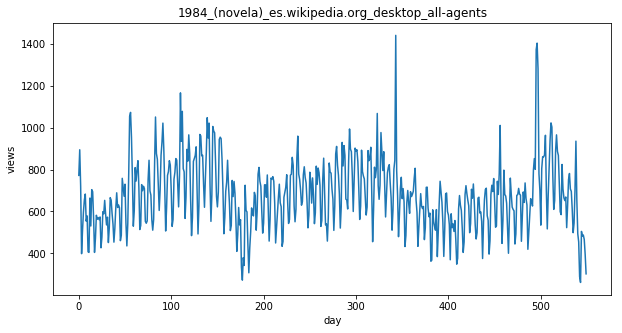

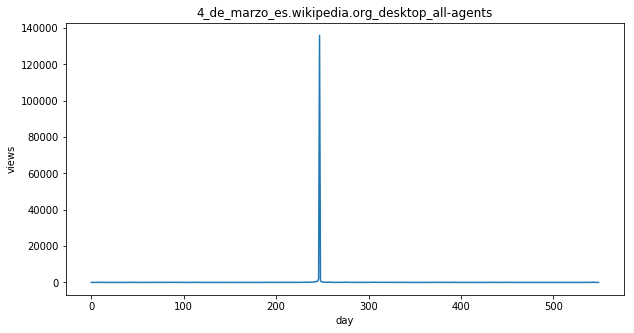

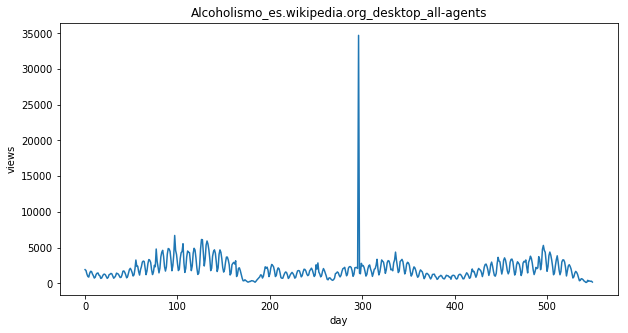

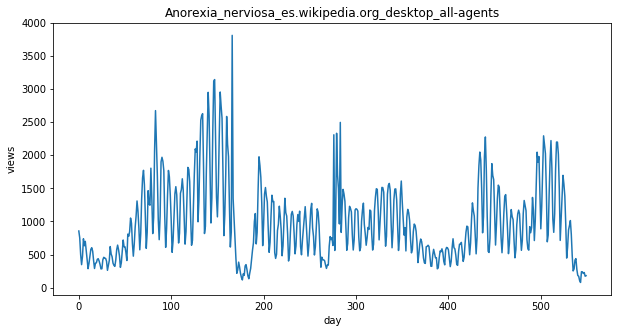

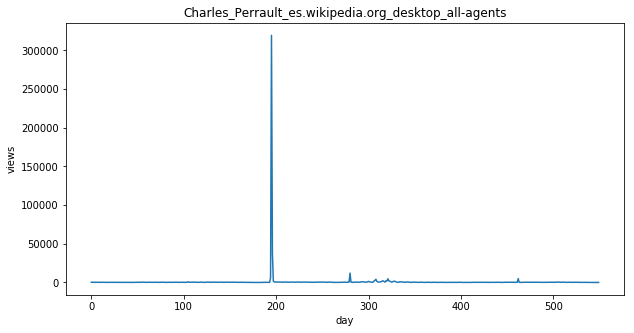

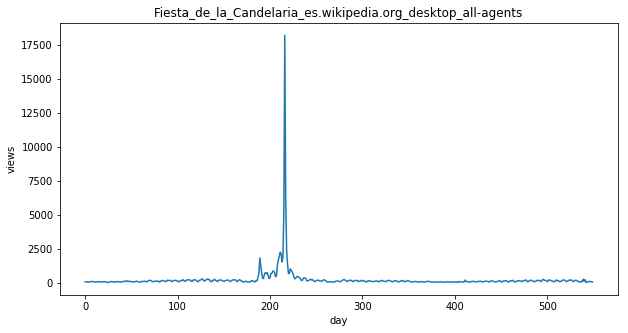

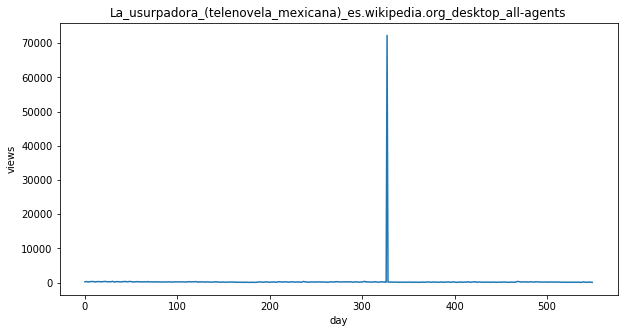

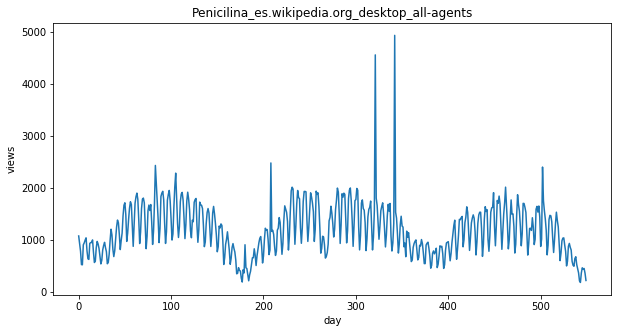

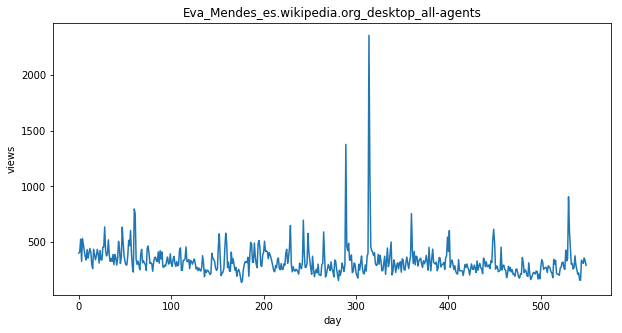

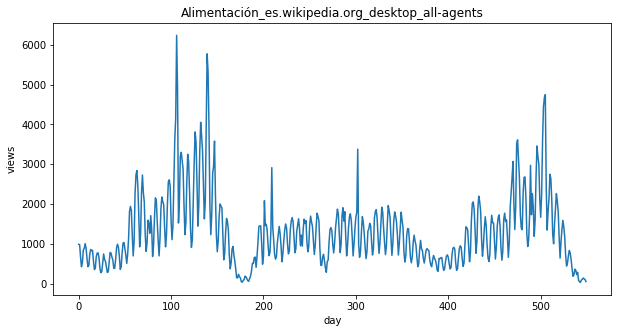

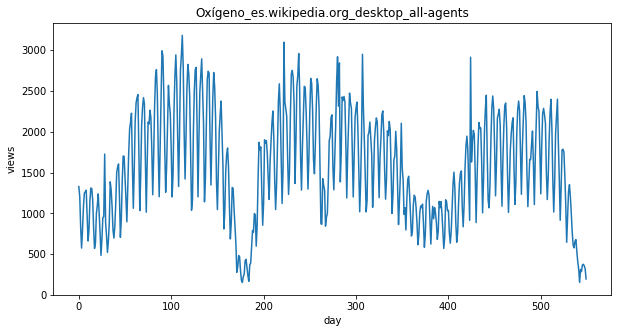

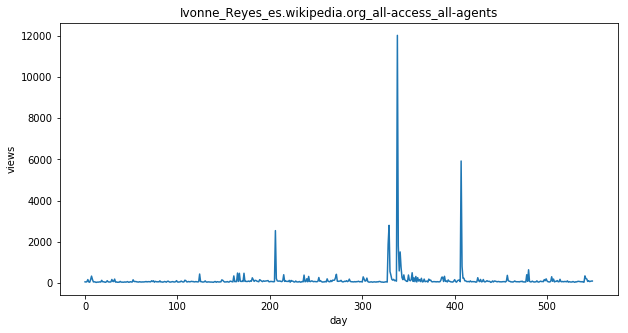

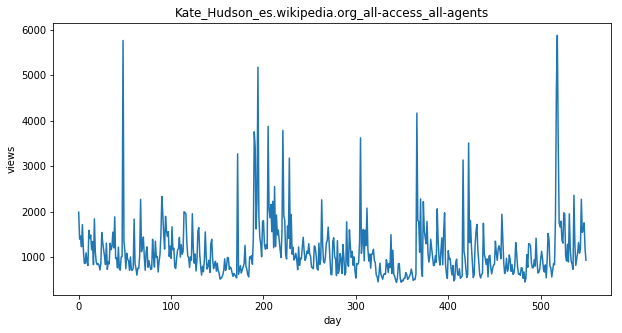

In [11]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('es',i)

This shows even more extreme short-term spikes than the English data. If some of these are just one or two days before reverting back to the mean, they may be a sign that something is wrong with the data. To deal with extremely short spikes, which we almost certainly won't be able to predict, something like a median filter can be used to remove them.

We see something very curious here, though. We see that a very strong periodic structure appears only in certain pages. The plots showing the strongest periodic structure actually all have something in common - they all seem to have something to do with health topics. The weekly structure might make sense if it's related to people seeing doctors and then consulting Wikipedia. The longer (~6 month) structure is harder to explain, especially without having any browser demographic information.

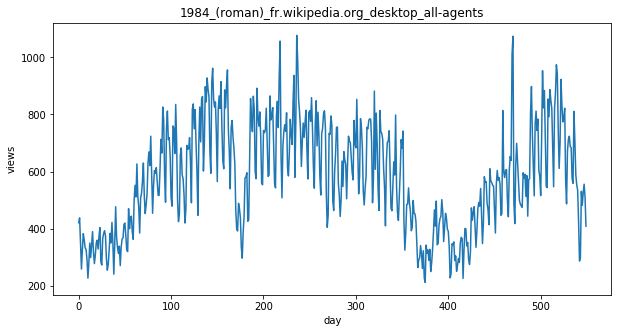

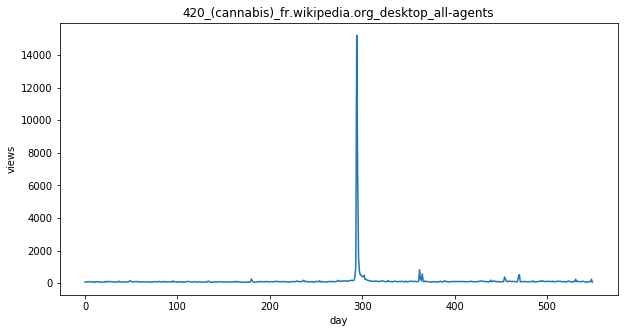

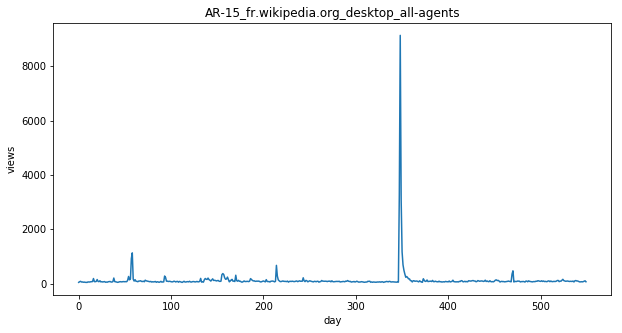

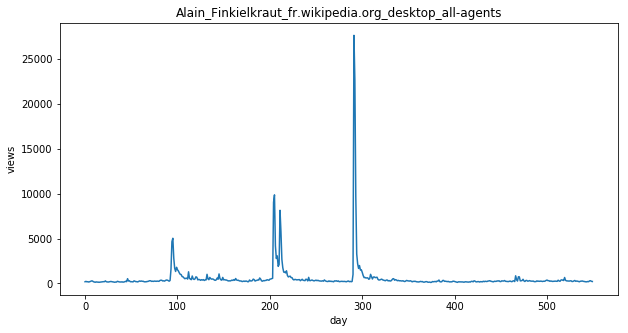

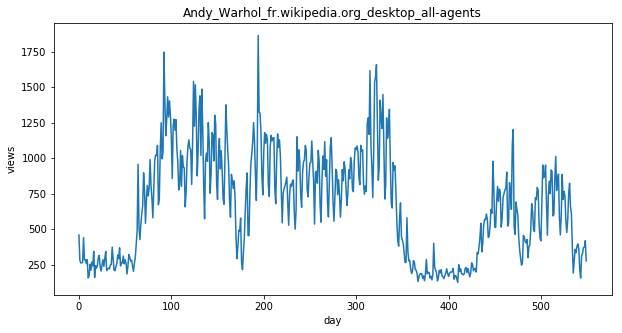

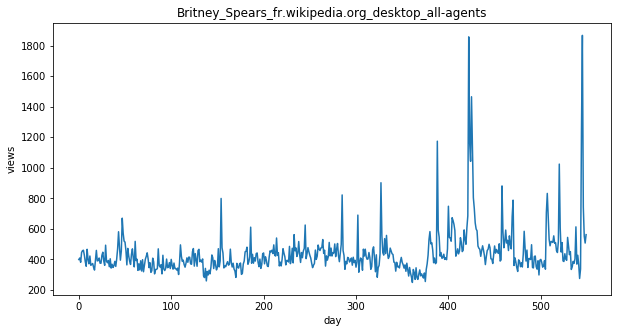

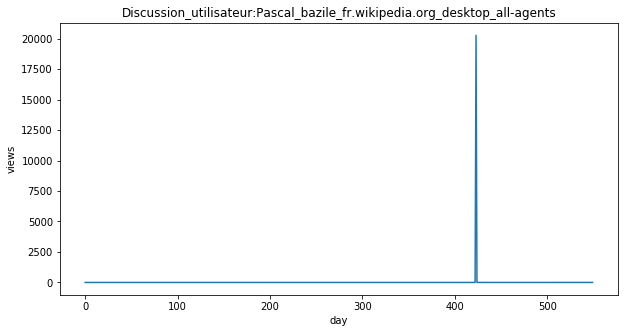

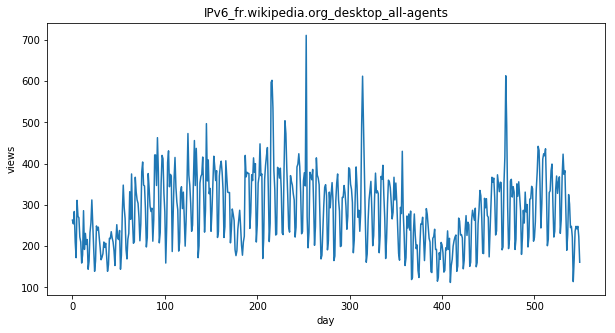

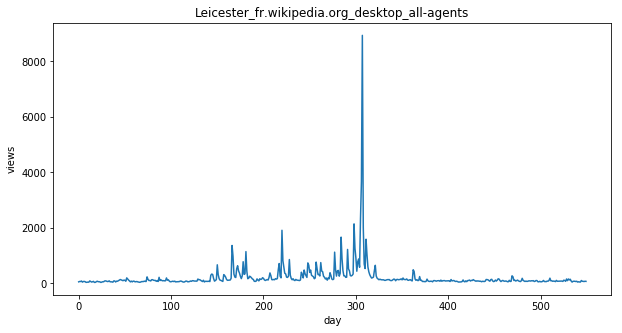

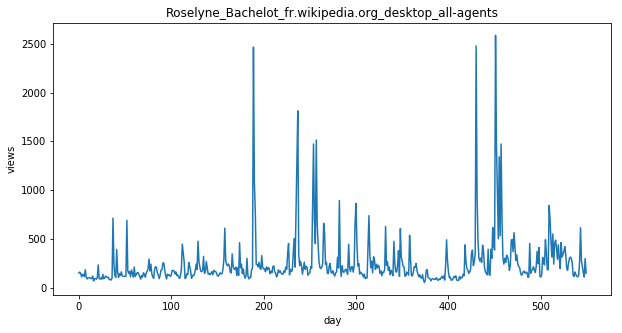

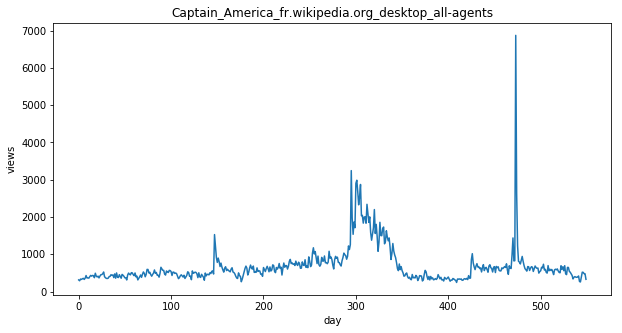

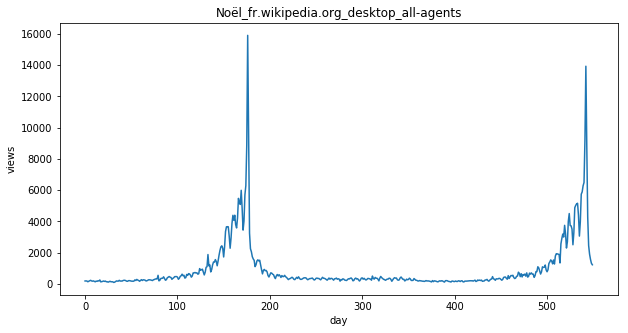

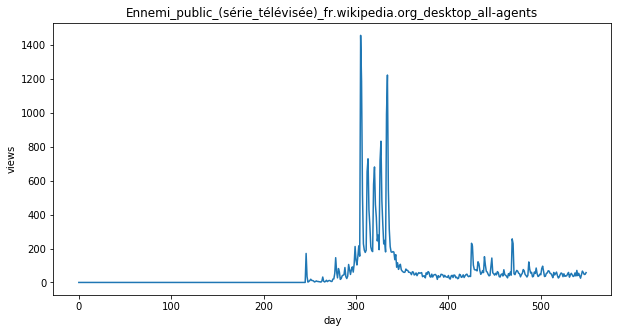

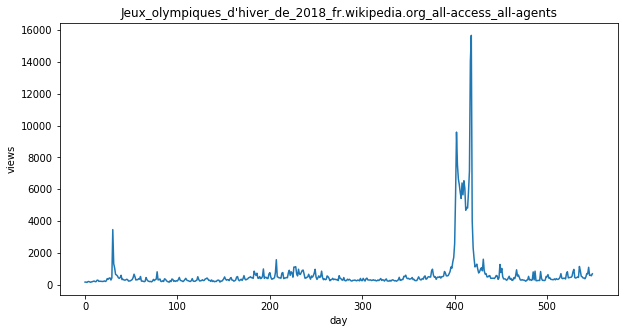

In [12]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('fr',i)

The French plots show more of the same. Wikipedia views again are hugely dependent on whether or not something is in the news. Leicester FC won the Premier League and received many page views around the championship. The Olympics caused a huge spike in traffic to their page. Christmas actually shows some interesting structure, with views steadily increasing throughout Advent.

# How does the aggregated data compare to the most popular pages?
I mentioned some of the potential problems with the aggregated data, so I'll now look at the most popular pages, which are generally going to be the main pages for the languages in this dataset.

In [13]:
# For each language get highest few pages
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.206618e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.774497e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.153985e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.304079e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.011848e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.921628e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.339931e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.332859e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.290204e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.243102e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415

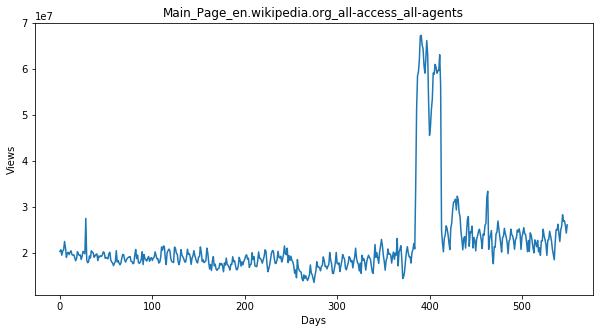

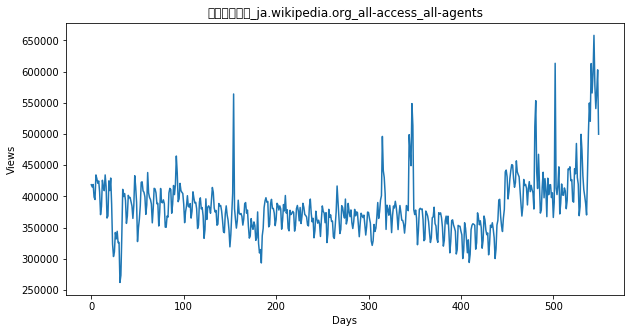

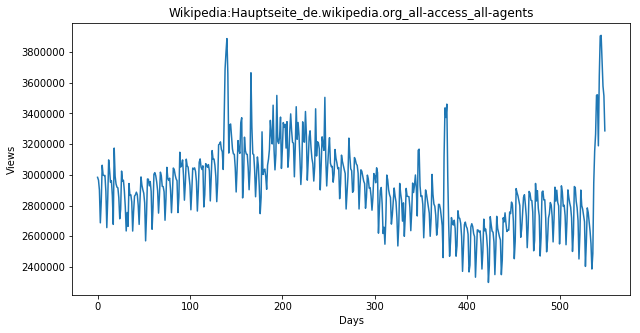

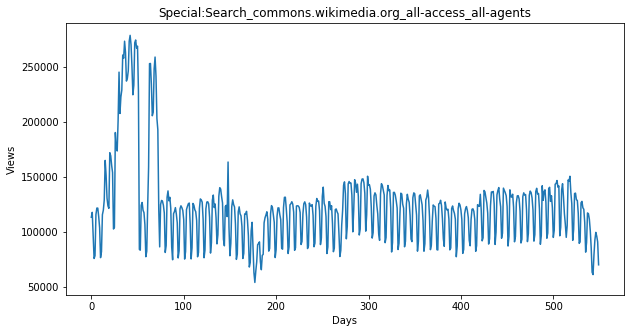

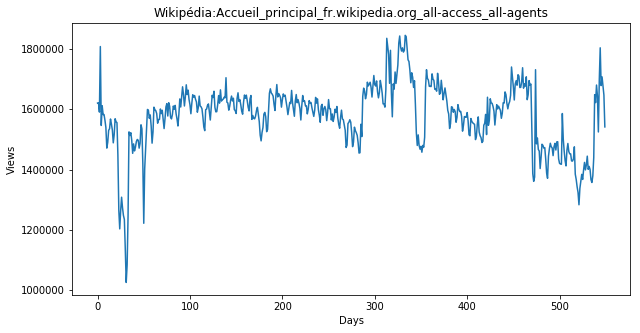

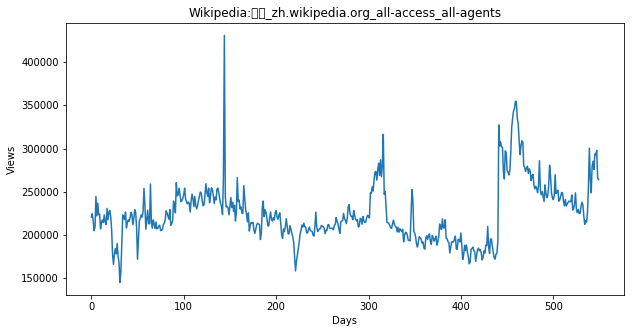

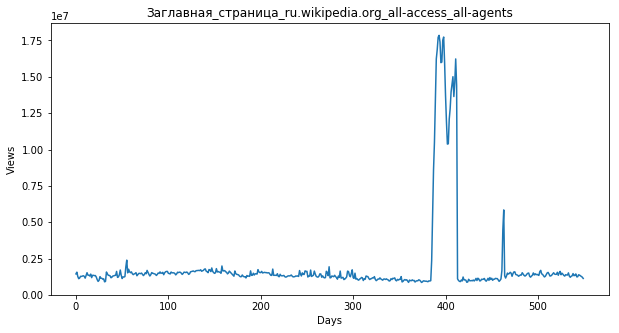

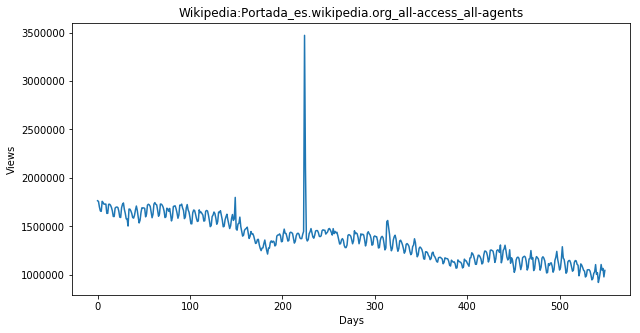

In [14]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key],cols]
    plt.plot(days,data)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.show()

Comparing these to the aggregated data, we see that things are mostly pretty similar. I'm actually quite surprised that the Olympics would have such a huge effect on a site like Wikipedia. I would say that the Japanese, Spanish, and media data differ the most. For media pages, this is expected since most people will access pages via links from other sites rather than through the main page or search function. The fact that some of the languages show large differences between the main page and the aggregated data suggests that the dataset is perhaps not very representative of all traffic to Wikipedia.

# More Analysis Tools

The statsmodels package includes quite a few tools for doing time series analysis. Here, I show the autocorrelation and partial autocorrelation for the most-viewed page for each language. Both of these show correlations of the signal with a delayed version of itself. At each lag, the partial autocorrelation tries to show the correlation at that lag after removing correlations at shorter lags.

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


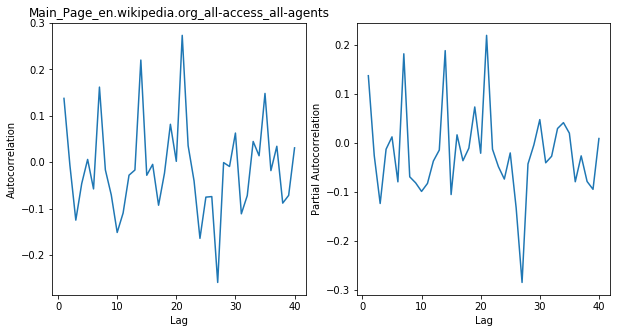

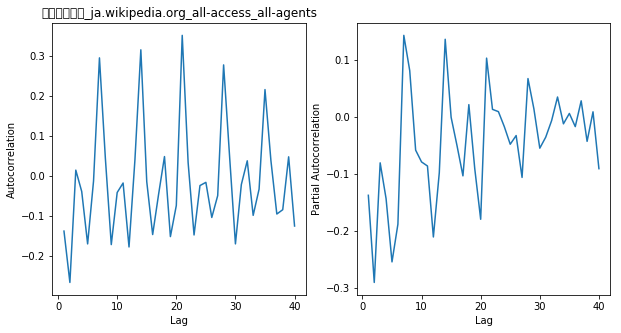

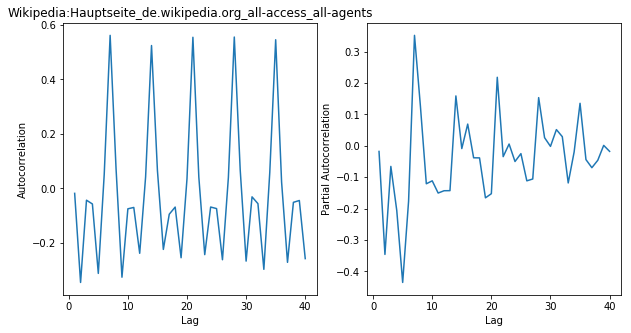

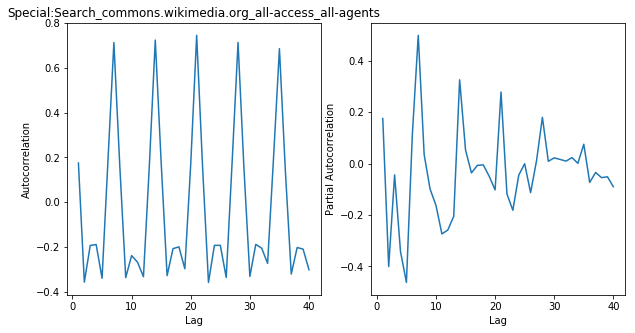

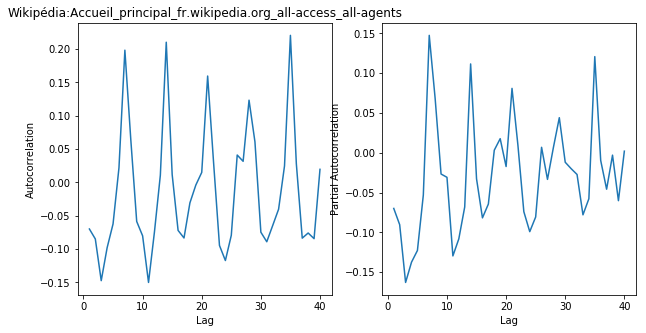

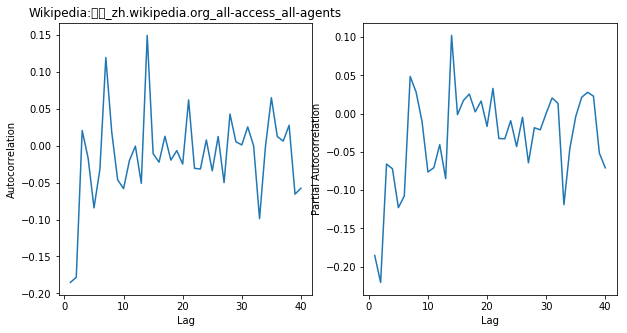

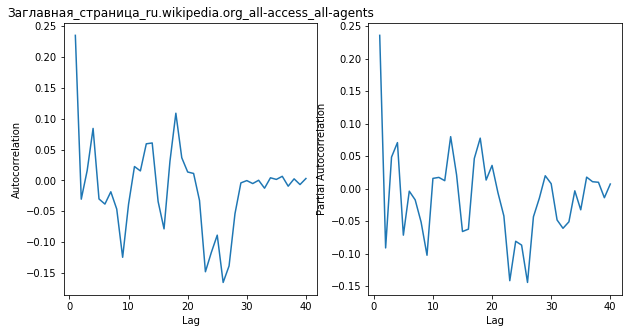

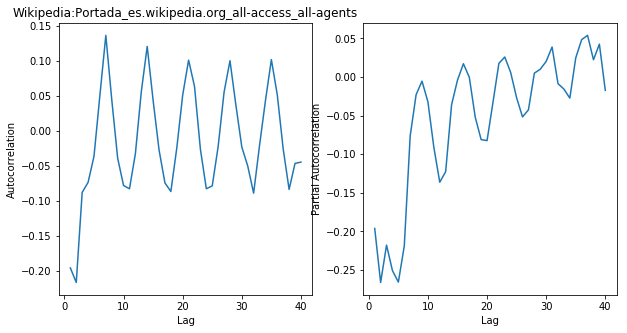

In [15]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in top_pages:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key],cols])
    data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show()

We see in most cases strong correlations and anticorrelations every 7 days due to weekly effects. For the partial autocorrelation, the first week seems to be the strongest and then things start settling down.

# Making Predictions
The baseline given so far is for guessing 0 views for everything. There are a few other easy benchmarks we can try out:

 - Average number of views for that page (constant value)
 - Linear regression
 - More complicated regression curves

But we've also seen that the data for related topics seems to be correlated and that topics that are in the news get a lot of traffic, so this maybe points to some ways to improve things. Unfortunately, with the different languages, training a model to identify related topics may be quite difficult. However, trying to cluster similar topics using just the data rather than the page name might help us out a bit. We could potentially smooth out some of the unpredictable spikes and could maybe use high-view pages to reduce effects of statistical fluctuations on low-view pages.

I also wonder if something like a recurrent neural net might help out here if we want to try out more complicated methods.

As an example, I look at ARIMA models for a small set of pages.

# ARIMA Models

Statsmodels also includes things like ARMA and ARIMA models that can be used to make predictions from time series. This data is not necessarily very stationary and often has strong periodic effects, so these may not necessarily work very well. I'll look at ARIMA predictions for the same set of very high viewcount pages.

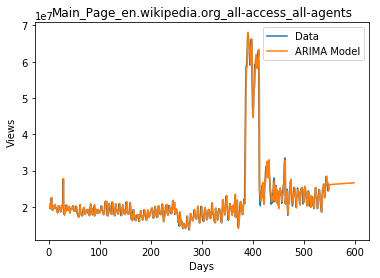

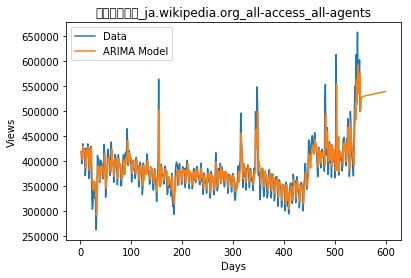

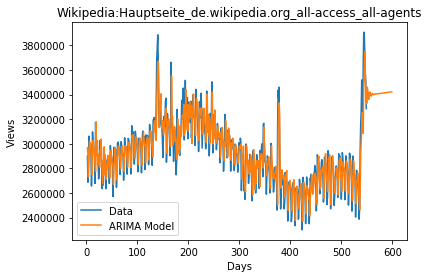

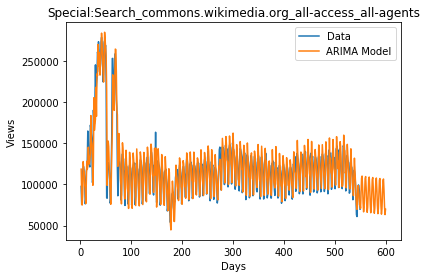

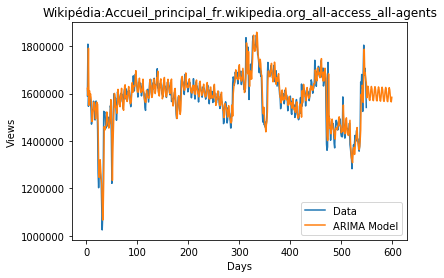

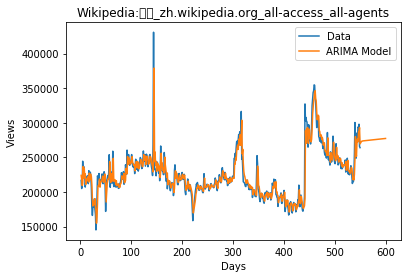

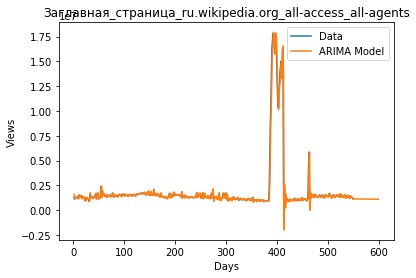

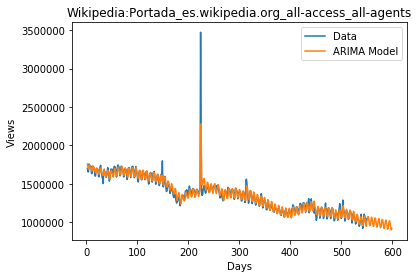

In [16]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0

    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

We see that the ARIMA model in some cases is able to predict the weekly substructure of the signal, which is good. In other cases it seems to just give a linear fit. This is potentially very useful.

However, if we just blindly apply the ARIMA model to the whole dataset, the results are not nearly as good as just using a basic median model. It still seems to have some interesting properties, so maybe we can combine this with another model to get better results. Or, maybe we can find some subset of data where we expect ARIMA to work better than our other models.

Unfortunately, the ARIMA classes in statsmodels are extremely slow, so to do this you'll probably want to parallelize this.